# Name: Peerasu Watanasirang

# Department of Computer Engineering, Faculty of Engineering
# Kasetsart University

# Internship subject: Application of SHAP algorithm in a pre-trained dataset with CNN in order to explain the prediction/detection results
# Supervisor: Lina Fahed, Associate Professor in Computer Science

## This subject is a part of Cooperative Education at IMT Atlantique Université Bretagne Loire
***

# Census income classification with XGBoost

This notebook demonstrates how to use XGBoost to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit github.

Gradient boosting machine methods such as XGBoost are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP (arXiv paper) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ XGBoost code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand XGBoost model predictions.

In [1]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

/Users/peerasu/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load dataset

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


## Train the model

In [3]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54662
[100]	test-logloss:0.36373
[200]	test-logloss:0.31793
[300]	test-logloss:0.30061
[400]	test-logloss:0.29207
[500]	test-logloss:0.28678
[600]	test-logloss:0.28381
[700]	test-logloss:0.28181
[800]	test-logloss:0.28064
[900]	test-logloss:0.27992
[1000]	test-logloss:0.27928
[1018]	test-logloss:0.27935


## Classic feature attributions

Here we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

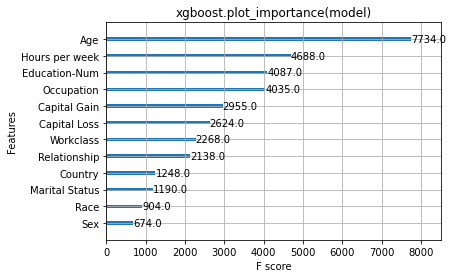

In [4]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

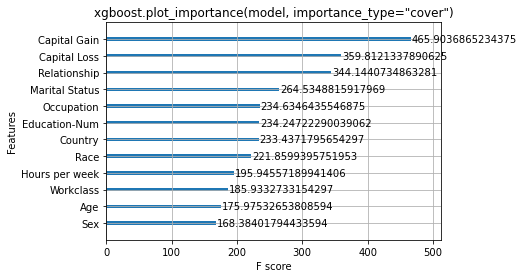

In [5]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

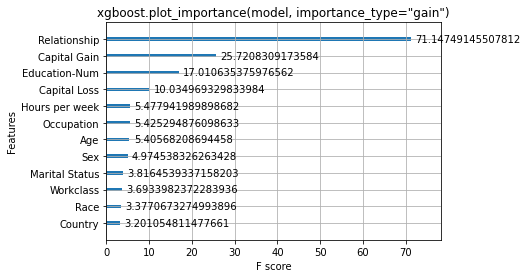

In [6]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## Explain predictions

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (32561 samples).

In [7]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# <font color=blue>Local Interpretation</font>
### 1. Visualize a single prediction

Note that we use the “display values” data frame so we get nice strings instead of category codes.

In [8]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

- As a matter of fact, all of the features (Sex, Age, Education-Num) values lead to the prediction value of `-3.67`, which is then "transformed" to a value of 1. Here, by all values I mean even those that are not shown in the plot. However, SHAP plots the top most influential features for the sample under study. Features in red color influence positively, i.e. drag the prediction value closer to 1, features in blue color - the opposite.
- The base value is the average of all output values of the model on the training, which in this case is `-1.147`.
- `-3.67` is the model output for your sample with index 0. This is the `raw` value which is then transformed into probability space, to give you the final output of 0 and 1 (< 0.5 and > 0.5).
***

<font color=blue>__More precisely:__ SHAP values to explain the predicted annual income probabilities of one individual. The baseline – the average predicted probability is `-3.67`. The man has a low predicted income of `-3.67`. Income increasing features such as `Education-Num` are offset by decreasing effects such as the `Relationship` and `Capital Gain`.
</font>
***

__Reference: For more details, you can read the following:__

In [9]:
from IPython.display import IFrame
IFrame('https://christophm.github.io/interpretable-ml-book/shap.html', width = 800, height = 450)

# <font color=blue>Global Interpretation</font>
### 2. Visualize many predictions

To keep the browser happy we only visualize 1,000 individuals.

In [10]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

You can cluster your data with the help of Shapley values. The goal of clustering is to find groups of similar instances. Normally, clustering is based on features. Features are often on different scales. For example, height might be measured in meters, color intensity from 0 to 100 and some sensor output between -1 and 1. The difficulty is to compute distances between instances with such different, non-comparable features.

SHAP clustering works by clustering the Shapley values of each instance. This means that you cluster instances by explanation similarity. All SHAP values have the same unit – the unit of the prediction space. You can use any clustering method. The above graph uses hierarchical agglomerative clustering to order the instances.

The plot consists of many force plots, each of which explains the prediction of an instance. We rotate the force plots vertically and place them side by side according to their clustering similarity.
***

<font color=blue>__More precisely:__ SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. One cluster stands out on the left, it is a group with a high predicted individual making over $50K a year in annual income.</font>
***

__Reference: For more details, you can read the following:__

In [11]:
from IPython.display import IFrame
IFrame('https://christophm.github.io/interpretable-ml-book/shap.html', width = 800, height = 450)

## 3. Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

The idea behind SHAP feature importance is simple: Features with large absolute Shapley values are important. Since we want the global importance, we average the absolute Shapley values per feature across the data.

Next, we sort the features by decreasing importance and plot them. The following figure shows the SHAP feature importance for the trained dataset before predicting an individual making over $50K a year in annual income.
***

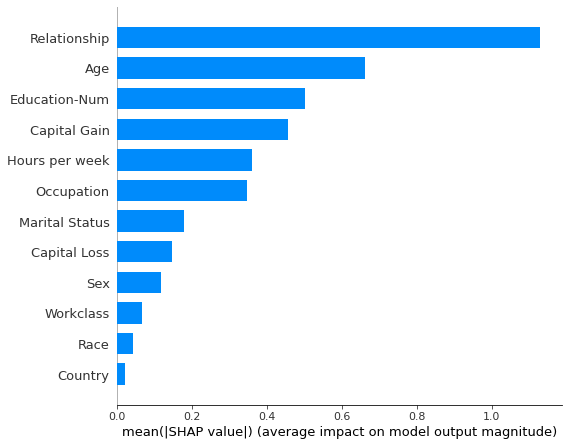

In [12]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

<font color=blue>__More precisely:__ SHAP feature importance measured as the mean absolute Shapley values. The status of the `Relationship` was the most important feature, changing the predicted individual making over $50K a year in annual income on average by 150 percentage points (1.5 on x-axis). And the least important feature is `Country`. On the y-axis, it shows all features from the most important one, to the least important one in order.</font>
***

__Reference: For more details, you can read the following:__

In [13]:
from IPython.display import IFrame
IFrame('https://christophm.github.io/interpretable-ml-book/shap.html', width = 800, height = 450)

## 4. SHAP Summary Plot

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance. In a summary plot, for each variable, every instance of the dataset appears as it's own point. The points are distributed horizontally along the x-axis according to their SHAP value. In places where there is a high density of SHAP values, the points are stacked vertically.

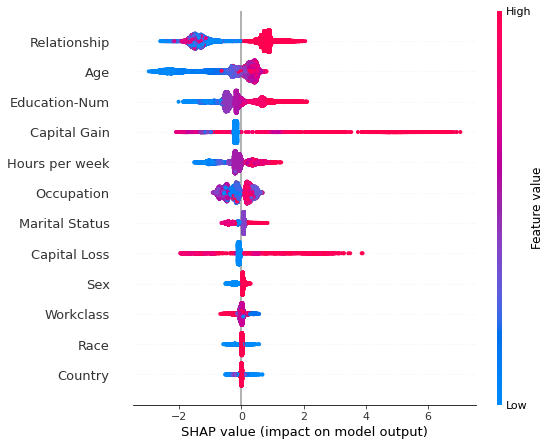

In [14]:
shap.summary_plot(shap_values, X)

<font color=blue>__More precisely:__ Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the `Relationship` feature has more total model impact than the `Captial Gain` feature, but for those samples where `Capital Gain` matters it has more impact than `Age`. In other words, `Capital Gain` effects a few predictions by a large amount, while `Age` effects all predictions by a smaller amount. But `Relationship` feature still has the highest total model impact on this summary plot. All the little dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations. For this dataset, the x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature. For example for the `Age` feature in the plot above, we can see that `Age` is the second most important feature on average. For instance, we see that lower values of `Age` have negative SHAP values (the points extending towards the left are increasingly blue) and higher values of `Age` have such a little positive SHAP values (the points extending towards the right are increasingly red in the stacked). This indicates that more young (blue) people are less likely to make over \$50k.</font>
***

__Reference: For more details, you can read the following:__

In [15]:
from IPython.display import IFrame
IFrame('https://christophm.github.io/interpretable-ml-book/shap.html', width = 800, height = 450)

In [16]:
from IPython.display import IFrame
IFrame('https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/', width = 800, height = 450)

## 5. SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

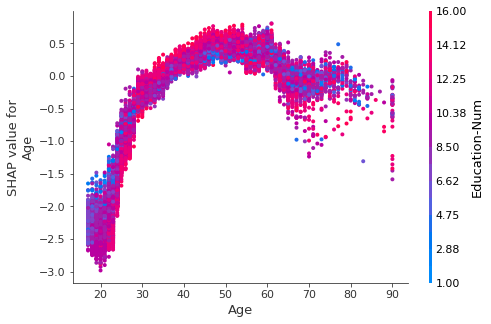

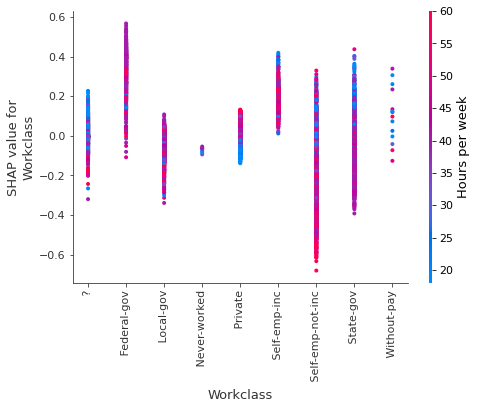

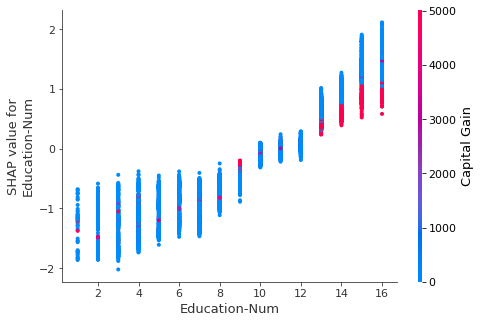

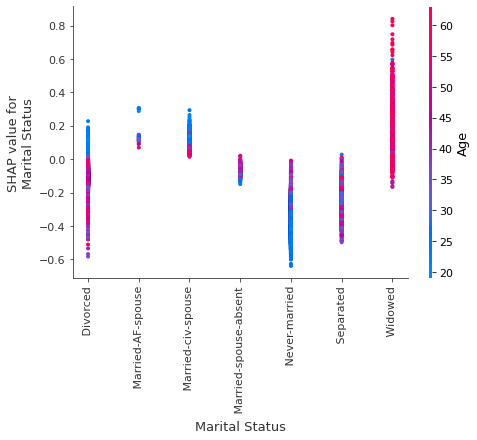

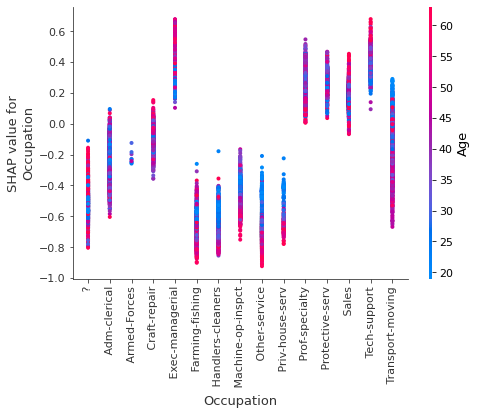

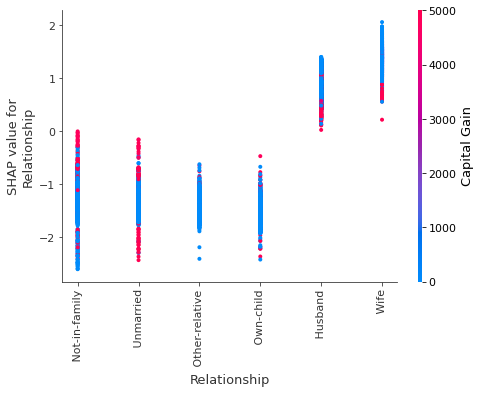

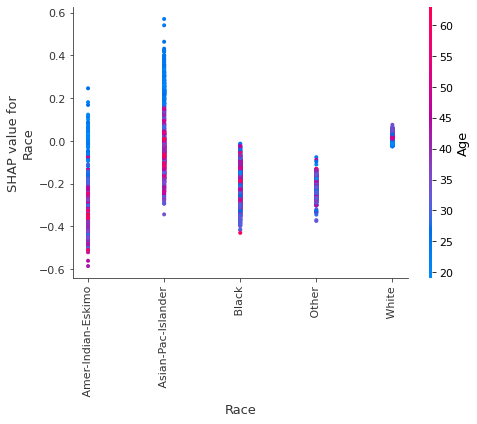

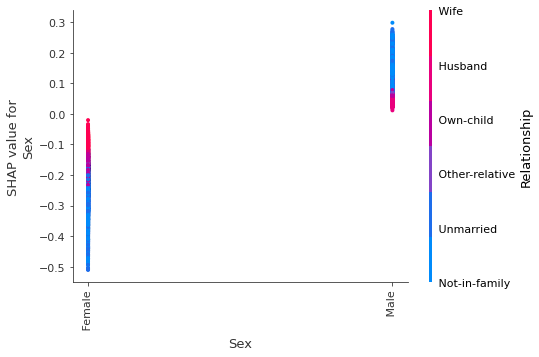

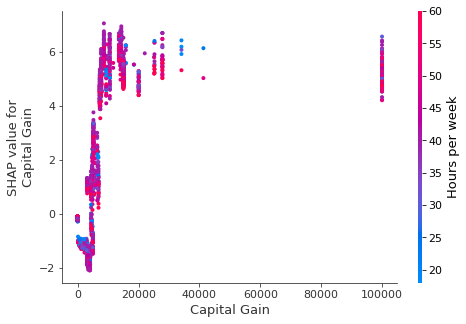

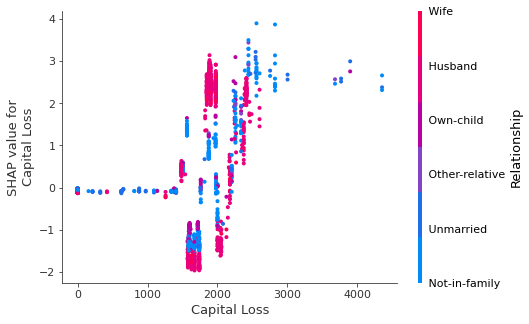

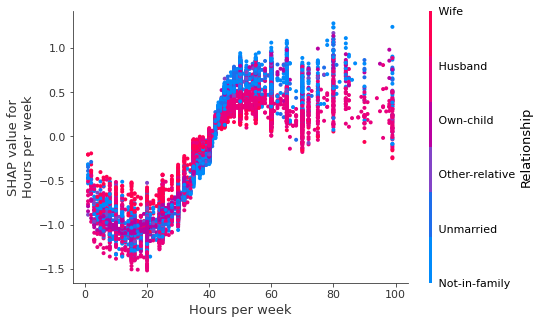

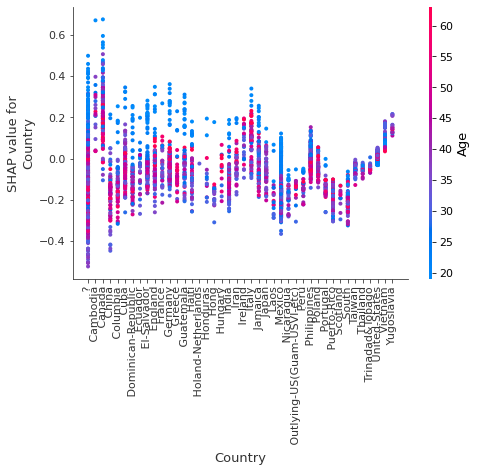

In [17]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

SHAP feature dependence might be the simplest global interpretation plot: 1) Pick a feature. 2) For each data instance, plot a point with the feature value on the x-axis and the corresponding Shapley value on the y-axis. 3) Done.

<font color=blue>__More precisely:__ Since there are a lot of dependence plots here, I will pick only two plots for an example. 1) SHAP dependence plot for `Education-Num` on `Age`. SHAP feature dependence plot with interaction visualization. `Age` values interacts with `Education-Num`. In cases close to 20 years old, the occurence of a `Education-Num` increases the predicted of an indivadual making. For more years on `Age` the high occurence of a `Education-Num` reduces the predicted of an individual making. 2) SHAP dependence plot for `Capital Gain` on `Hours per week`. As you can see that when compared to 0 capital gain, the lower the `Capital Gain`, the more lower predicted probability of `Hours per week`. As the two features have a direct variation to each other. The more `Capital Gain`, the more `Hours per week` also.</font>
***

__Reference: For more details, you can read the following:__

In [18]:
from IPython.display import IFrame
IFrame('https://christophm.github.io/interpretable-ml-book/shap.html', width = 800, height = 450)

## 6. Simple supervised clustering

Rather than cluster on the raw data directly (or an embedding thereof), supervised clustering first converts the raw data into SHAP values. This involves using the raw data to train a supervised machine learning model, and then computing SHAP values with this trained model. The result is an array of equal dimensions to that of the raw data, but with values that are determined by how informative the data is in relation to the target variable.

Clustering people by their shap_values leads to groups relevent to the prediction task at hand (their earning potential in this case).

__The Advantages of Supervised Clustering__

There are two interrelated benefits to using SHAP values for cluster analysis:

- Computing SHAP values serves as a pre-processing step that rescales raw data into common units (the output of the supervised prediction model). This elegantly handles the common challenge where we want to cluster data containing features with very different units and scales (e.g. dollars, metres, colour etc.)
- SHAP values weight the data by a measure of importance that emphasises the most informative features whilst minimising the influence of irrelevant features. Traditional clustering biases features based on the magnitude of their distributions, regardless of their actual information content. Using SHAP values de-noises the data of irrelevant information and amplifies features proportional to the signal that they generate.
These properties lead to supervised clustering producing highly-differentiated, characterisable clusters that are easy to discern and interpret.

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [20]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

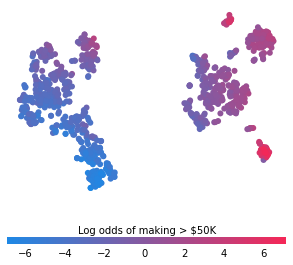

In [21]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

The raw data embedding contains little structure, with almost complete overlap between the two classes of the target variable, y. However, the SHAP values embedding clearly recovers each class' two underlying clusters.

<font color=blue>__More precisely:__ Depending on your use case for supervised clustering, you may want to apply dimensionality reduction to only one of the target variable's classes. In this case, we apply the SHAP value on the `Log odds of making more than $50K` and generate it out to display on the supervised clustering.</font>
***

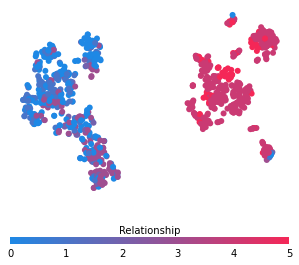

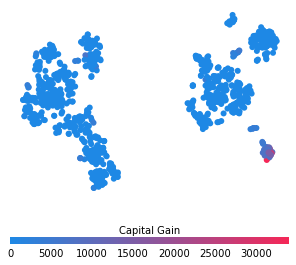

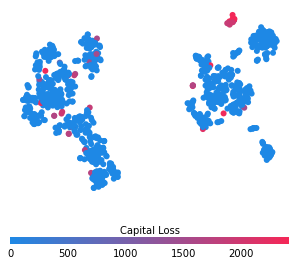

In [22]:
for feature in ["Relationship", "Capital Gain", "Capital Loss"]:
    f = pl.figure(figsize=(5,5))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    pl.show()

<font color=blue>__More precisely:__ And for these three plots, we display the SHAP supervised clustering plot on `Relationship`, `Capital Gain`, and `Capital Loss` features. You can see that all three of them clearly have two underlying clusters. Which `Capital Gain` and `Capital Loss` are both having a very less SHAP values on both clusters. In the other hand, the `Relationship` feature have the highly SHAP values. Because as you already see in the __summary plot__, the `Relationship` feature has more total model impact than the `Captial Gain` and `Capital Loss` feature.</font>
***

__Reference: For more details, you can read the following:__

In [23]:
from IPython.display import IFrame
IFrame('https://www.aidancooper.co.uk/supervised-clustering-shap-values/', width = 800, height = 450)

## 7. Train a model with only two leaves per tree and hence no interaction terms between features

In [24]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model_ind = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54113
[100]	test-logloss:0.35499
[200]	test-logloss:0.32848
[300]	test-logloss:0.31901
[400]	test-logloss:0.31331
[500]	test-logloss:0.30930
[600]	test-logloss:0.30619
[700]	test-logloss:0.30371
[800]	test-logloss:0.30184
[900]	test-logloss:0.30035
[1000]	test-logloss:0.29913
[1100]	test-logloss:0.29796
[1200]	test-logloss:0.29695
[1300]	test-logloss:0.29606
[1400]	test-logloss:0.29525
[1500]	test-logloss:0.29471
[1566]	test-logloss:0.29441


In [25]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


invalid value encountered in true_divide
invalid value encountered in true_divide


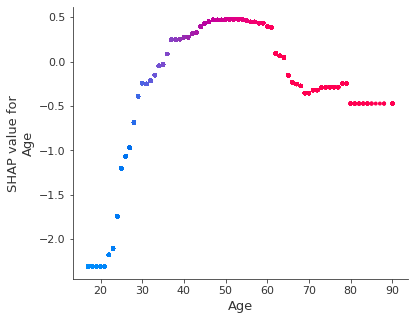

invalid value encountered in true_divide
invalid value encountered in true_divide


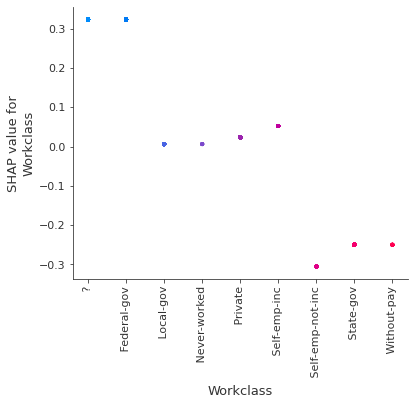

invalid value encountered in true_divide
invalid value encountered in true_divide


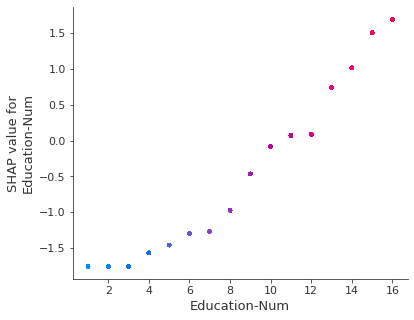

invalid value encountered in true_divide
invalid value encountered in true_divide


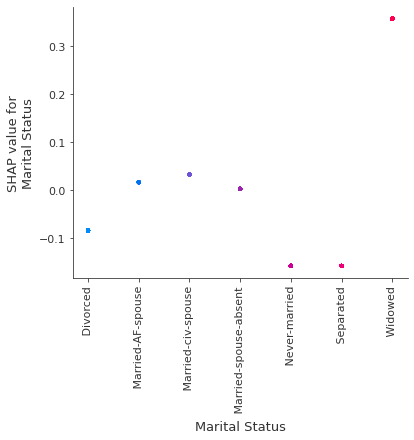

invalid value encountered in true_divide
invalid value encountered in true_divide


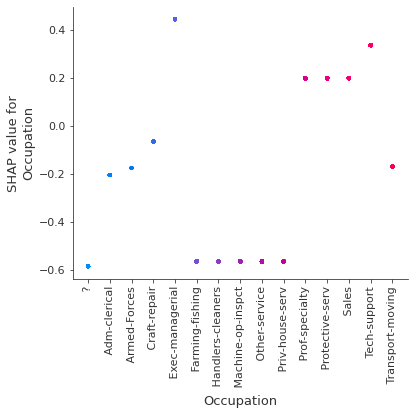

invalid value encountered in true_divide
invalid value encountered in true_divide


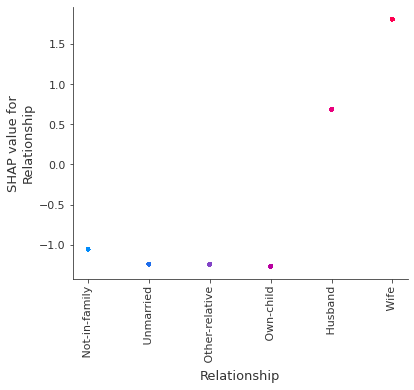

invalid value encountered in true_divide
invalid value encountered in true_divide


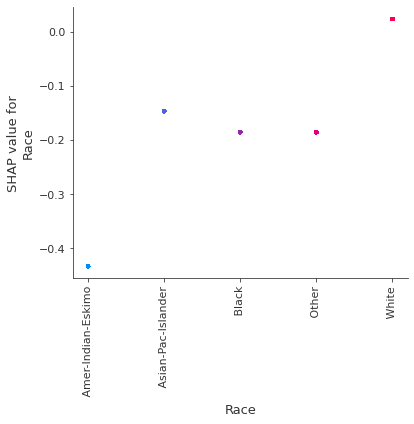

invalid value encountered in true_divide
invalid value encountered in true_divide


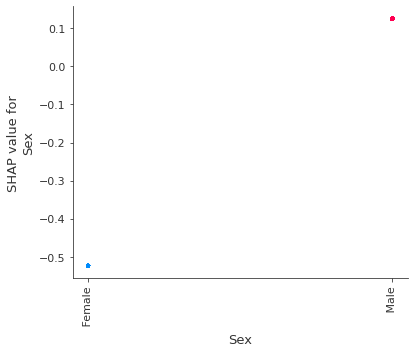

invalid value encountered in true_divide
invalid value encountered in true_divide


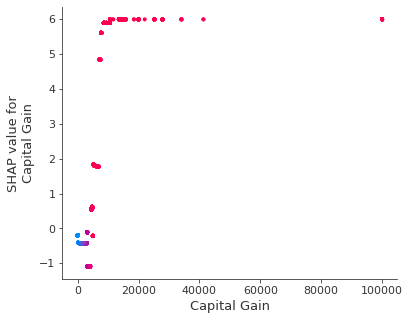

invalid value encountered in true_divide
invalid value encountered in true_divide


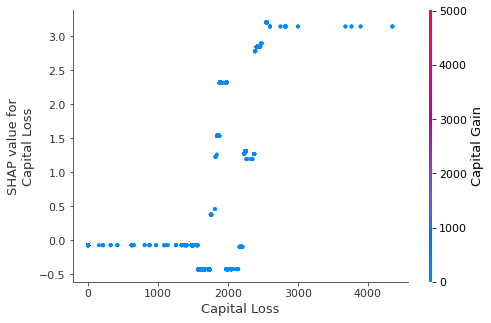

invalid value encountered in true_divide
invalid value encountered in true_divide


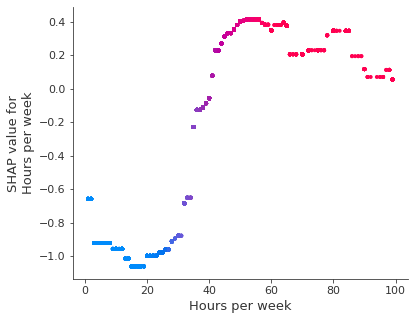

invalid value encountered in true_divide
invalid value encountered in true_divide


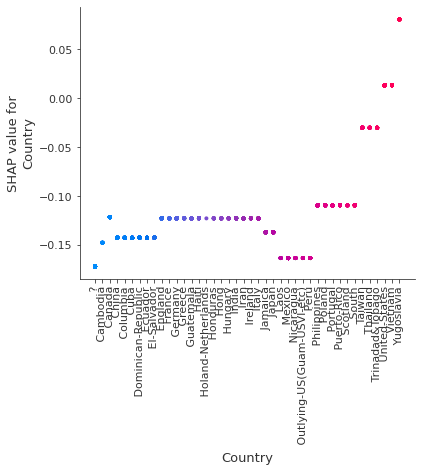

In [26]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X_display)

<font color=blue>__More precisely:__ In these plots, we train the model with only two leaves per tree. I will pick two plots to explain for an example. The first plot is the dependence plot of `Age` feature. You can see that now the density of SHAP values are not the same as topic 5. The density is now much less than the normal dependence plot. In cases close to 20 years old, a few years of `Age` lower the predicted probability, and a high years of `Age` increases the predicted probability of an individual making over 50K a year in annual income. The second example is for the `Education-Num` feature. Also, the density of SHAP values are not the same as the previous dependence plot. In cases close to 0 education number, a few number of `Education-Num` lower the predicted probability, and a high number of `Education-Num` increases the predicted probability of an individual making over $50K a year in annual income.</font>
***

__Reference: For more details, you can read the following:__

In [27]:
from IPython.display import IFrame
IFrame('https://christophm.github.io/interpretable-ml-book/shap.html#clustering-shapley-values', width = 800, height = 450)